In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, precision_recall_curve

2025-02-24 11:53:15.783992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 11:53:15.792383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740394395.801360  123645 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740394395.804012  123645 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 11:53:15.814620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
df=pd.read_csv("datasets/sensor.csv")
sensors_to_drop = ['Unnamed: 0', 'timestamp','sensor_15', 'sensor_50']
df = df.drop(columns=sensors_to_drop)

sensor_cols = df.columns[df.isnull().any()].tolist()
df[sensor_cols] = df[sensor_cols].interpolate(method='linear')

# If any remaining NaNs, use forward/backward fill
df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
df[sensor_cols] = df[sensor_cols].fillna(method='bfill')
y=df["machine_status"]
X=df.drop(columns=['machine_status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

/tmp/ipykernel_123645/2993191630.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
/tmp/ipykernel_123645/2993191630.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='bfill')


In [3]:
WINDOW_SIZE = 30  # Past 30 minutes
HORIZON = 8      # Predict failure within 60 minutes
NUM_FEATURES = 50 # Number of sensors

# Step 1: Create sequences and binary labels
def create_sequences(X, y, window_size, horizon):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size - horizon + 1):
        seq = X[i:i + window_size]
        future_labels = y[i + window_size:i + window_size + horizon]
        label = 1 if "BROKEN" in future_labels else 0
        if y[i + window_size - 1] == "NORMAL":  # Only predict from NORMAL
            X_seq.append(seq)
            y_seq.append(label)
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, WINDOW_SIZE, HORIZON)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, WINDOW_SIZE, HORIZON)

In [4]:
neg_indices = np.where(y_train_seq == 0)[0]
pos_indices = np.where(y_train_seq == 1)[0]
np.random.seed(42)
neg_indices_sampled = np.random.choice(neg_indices, size=len(pos_indices) * 2, replace=False)  # 2:1 ratio
balanced_indices = np.concatenate([neg_indices_sampled, pos_indices])
np.random.shuffle(balanced_indices)

X_train_seq_bal = X_train_seq[balanced_indices]
y_train_seq_bal = y_train_seq[balanced_indices]

def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

In [5]:
# Step 3: Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(WINDOW_SIZE, NUM_FEATURES), return_sequences=True),
    Dropout(0.3),
    LSTM(128),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=focal_loss(gamma=1.0, alpha=0.7),  # Alpha favors positives
              metrics=['Precision', 'Recall'])

model.summary()

2025-02-24 11:53:19.432942: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1740394399.433826  123645 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11647 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/henrik/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,137 (606.00 KB)

 Trainable params: 155,137 (606.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_seq_bal, y_train_seq_bal,
                    epochs=150,
                    batch_size=256,
                    validation_data=(X_test_seq, y_test_seq),
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/150


I0000 00:00:1740394400.963806  123764 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Precision: 0.3190 - Recall: 0.9250 - loss: 2.8014 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 2.7401
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step - Precision: 0.4694 - Recall: 0.5750 - loss: 2.7493 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 2.6834
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - Precision: 0.3333 - Recall: 0.0250 - loss: 2.7026 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 2.6219
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step - Precision: 1.0000 - Recall: 0.0250 - loss: 2.6541 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 2.5565
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 2.6031 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 2.4869
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 2.5548 - val_Precision: 0.00

In [ ]:
y_pred_prob = model.predict(X_test_seq)
y_pred = (y_pred_prob > 0.5).astype(int)

#y_pred_prob = model.predict(X_test_seq)
thresholds = [0.5, 0.3, 0.1]  # Test different thresholds

for thresh in thresholds:
    y_pred = (y_pred_prob > thresh).astype(int)
    precision = precision_score(y_test_seq, y_pred)
    recall = recall_score(y_test_seq, y_pred)
    f1 = f1_score(y_test_seq, y_pred)
    print(f"\nThreshold {thresh}:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Predicted positives: {np.sum(y_pred)} (True positives: {np.sum(y_test_seq)})")

# Step 7: Prediction function for new data
def predict_failure(X_new, model, scaler, window_size=WINDOW_SIZE):
    X_new_scaled = scaler.transform(X_new)
    X_new_seq, _ = create_sequences(X_new_scaled, np.array(["NORMAL"]*len(X_new)), window_size, 0)
    preds = model.predict(X_new_seq)
    return preds

# Debugging: Check a few sequences around a positive label
pos_test_indices = np.where(y_test_seq == 1)[0]
if len(pos_test_indices) > 0:
    sample_idx = pos_test_indices[0]
    print(f"\nSample positive sequence prediction:")
    print(f"True label: {y_test_seq[sample_idx]}")
    print(f"Predicted prob: {y_pred_prob[sample_idx][0]:.4f}")

2616/2616 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Threshold 0.5:
Precision: 0.0100
Recall: 0.3417
F1-Score: 0.0194
Predicted positives: 4104 (True positives: 120)

Threshold 0.3:
Precision: 0.0034
Recall: 1.0000
F1-Score: 0.0068
Predicted positives: 35366 (True positives: 120)

Threshold 0.1:
Precision: 0.0015
Recall: 1.0000
F1-Score: 0.0030
Predicted positives: 80762 (True positives: 120)

Sample positive sequence prediction:
True label: 1
Predicted prob: 0.3738


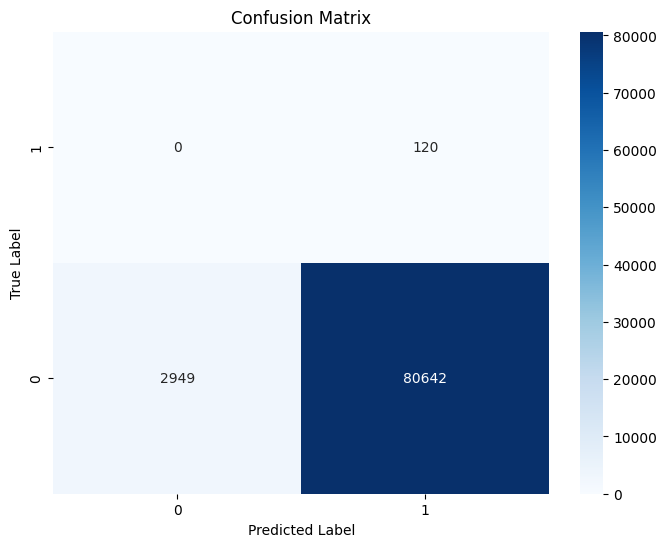

In [ ]:
cm = confusion_matrix(y_test_seq, y_pred)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(2), yticklabels=range(2))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.gca().invert_yaxis()
plt.show()

Window size 32 errors 46k
Window size 24 8/16 errors 3k